In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import random

# Data Preparation

### Create dataset

In [16]:
# Create datasets

no_dementia_image_paths = os.listdir('/home/athimmaudayakumar/data_multiclass_classification/No_Dementia')
mild_dementia_image_paths = os.listdir('/home/athimmaudayakumar/data_multiclass_classification/Mild_Dementia')
advanced_dementia_image_paths = os.listdir('/home/athimmaudayakumar/data_multiclass_classification/Advanced_Dementia')

patient_ids = []
class_labels = []
image_paths = []
tracker = 0


prefix = '/data_multiclass_classification/Advanced_Dementia/'

for path in advanced_dementia_image_paths:
    patient_id = path.split('_')[1]
    if patient_id not in patient_ids:
        patient_subset = [path for path in advanced_dementia_image_paths if path.split('_')[1] == patient_id]
        chosen = random.sample(patient_subset, k=100)
        tracker += 1
        if tracker > 22:
            break
        for p in chosen:
            image_paths.append(prefix + p)
        for i in range(100):
            patient_ids.append(patient_id)
            class_labels.append(2)
    else:
        continue
    

prefix = '/data_multiclass_classification/Mild_Dementia/'
tracker = 0
for path in mild_dementia_image_paths:
    patient_id = path.split('_')[1]
    if patient_id not in patient_ids:
        patient_subset = [path for path in mild_dementia_image_paths if path.split('_')[1] == patient_id]
        chosen = random.sample(patient_subset, k=100)
        tracker += 1
        if tracker > 22:
            break
        for p in chosen:
            image_paths.append(prefix + p)
        for i in range(100):
            patient_ids.append(patient_id)
            class_labels.append(1)
    else:
        continue
    
prefix = '/data_multiclass_classification/No_Dementia/'
tracker = 0

for path in no_dementia_image_paths:
    patient_id = path.split('_')[1]
    if patient_id not in patient_ids:
        patient_subset = [path for path in no_dementia_image_paths if path.split('_')[1] == patient_id]
        chosen = random.sample(patient_subset, k=100)
        tracker += 1
        if tracker > 22:
            break
        for p in chosen:
            image_paths.append(prefix + p)
        for i in range(100):
            patient_ids.append(patient_id)
            class_labels.append(0)
    else:
        continue

In [17]:
df = pd.DataFrame([patient_ids, image_paths, class_labels]).transpose()
df.columns = ['patient_id', 'image_path', 'class_label']
df

,patient_id,image_path,class_label
0,0073,/data_multiclass_classification/Advanced_Demen...,2
1,0073,/data_multiclass_classification/Advanced_Demen...,2
2,0073,/data_multiclass_classification/Advanced_Demen...,2
3,0073,/data_multiclass_classification/Advanced_Demen...,2
4,0073,/data_multiclass_classification/Advanced_Demen...,2
...,...,...,...
6595,0266,/data_multiclass_classification/No_Dementia/OA...,0
6596,0266,/data_multiclass_classification/No_Dementia/OA...,0
6597,0266,/data_multiclass_classification/No_Dementia/OA...,0
6598,0266,/data_multiclass_classification/No_Dementia/OA...,0


### Train-Test Split (based on random selection of patients done in data_exploration.ipynb)

In [18]:
random.seed(62)
# Create separate dataframes for each class
class_0_df = df[df['class_label'].isin([0])]
class_1_df = df[df['class_label'].isin([1])]
class_2_df = df[df['class_label'].isin([2])]

train_choices_0 = random.sample(class_0_df['patient_id'].unique().tolist(), k=15)
train_choices_1 = random.sample(class_1_df['patient_id'].unique().tolist(), k=15)
train_choices_2 = random.sample(class_2_df['patient_id'].unique().tolist(), k=16)

test_choices_0 = []
for id in class_0_df['patient_id'].unique():
    if (id not in train_choices_0) and (id not in test_choices_0):
        test_choices_0.append(id)
    else:
        continue
test_choices_1 = []
for id in class_1_df['patient_id'].unique():
    if (id not in train_choices_1) and (id not in test_choices_1):
        test_choices_1.append(id)
    else:
        continue
test_choices_2 = []
for id in class_2_df['patient_id'].unique():
    if (id not in train_choices_2) and (id not in test_choices_2):
        test_choices_2.append(id)
    else:
        continue

print("Patient IDs for training set from class 0: ", train_choices_0)
print("Patient IDs for training set from class 1: ", train_choices_1)
print("Patient IDs for training set from class 2: ", train_choices_2)
print()
print("Patient IDs for testing set from class 0: ", test_choices_0)
print("Patient IDs for testing set from class 1: ", test_choices_1)
print("Patient IDs for testing set from class 2: ", test_choices_2)
print()

#Check that train and test sets have no overlapping participants
compare_0 = np.intersect1d(np.array(train_choices_0), np.array(test_choices_0))
if len(compare_0) > 0:
    print('INTERSECTING PATIENT ID\'S')
else:
    print("No intersecting ID\'s")
    
compare_1 = np.intersect1d(np.array(train_choices_1), np.array(test_choices_1))
if len(compare_1) > 0:
    print('INTERSECTING PATIENT ID\'S')
else:
    print("No intersecting ID\'s")

compare_2 = np.intersect1d(np.array(train_choices_2), np.array(test_choices_2))
if len(compare_2) > 0:
    print('INTERSECTING PATIENT ID\'S')
else:
    print("No intersecting ID\'s")
print()

# Create the training set dataframe
train_df = df[df['patient_id'].isin(train_choices_0 + train_choices_1 + train_choices_2)]
train_df = train_df.reset_index()
print("Number of participants in training set: ", int(len(train_df) / 100))

# Create the testing set dataframe
test_df = df[df['patient_id'].isin(test_choices_0 + test_choices_1 + test_choices_2)]
test_df = test_df.reset_index()
print("Number of participants in testing set: ", int(len(test_df) / 100))

print('Train Ratio: ', (len(train_df) / len(df)))
print('Test Ratio: ', (len(test_df) / len(df)))

Patient IDs for training set from class 0:  ['0371', '0145', '0328', '0292', '0211', '0059', '0047', '0141', '0030', '0002', '0136', '0132', '0299', '0162', '0061']
Patient IDs for training set from class 1:  ['0380', '0094', '0315', '0143', '0039', '0082', '0098', '0124', '0155', '0123', '0042', '0066', '0120', '0374', '0247']
Patient IDs for training set from class 2:  ['0035', '0351', '0278', '0028', '0052', '0031', '0073', '0056', '0137', '0316', '0134', '0268', '0373', '0269', '0122', '0185']

Patient IDs for testing set from class 0:  ['0356', '0321', '0343', '0075', '0232', '0325', '0266']
Patient IDs for testing set from class 1:  ['0084', '0226', '0335', '0158', '0041', '0060', '0362']
Patient IDs for testing set from class 2:  ['0223', '0308', '0184', '0053', '0291', '0382']

No intersecting ID's
No intersecting ID's
No intersecting ID's

Number of participants in training set:  46
Number of participants in testing set:  20
Train Ratio:  0.696969696969697
Test Ratio:  0.30303

# Data Pipeline

### Defining Transforms

In [19]:
# Importing the custom dataset class
from alzheimers_dataset_ViT import alzheimers_dataset
import torchvision.transforms as tf

In [74]:
# Simple transforms for baseline model
def repeat(x):
    return x.repeat(3, 1, 1)

transforms = tf.Compose([
    tf.Pad([0, 124,]),
    tf.Resize((224, 224)),
    tf.ToTensor(),
    torchvision.transforms.Lambda(repeat),
    tf.Normalize(mean=[0.1611921340227127], std=[0.1776019036769867]),
])

In [75]:
# Create datasets based on custom dataset class
root_dir = '/home/athimmaudayakumar/'

train_image_paths = train_df['image_path'].to_numpy()
train_labels = train_df['class_label'].to_numpy()
train_set = alzheimers_dataset(root_dir=root_dir, image_paths=train_image_paths, labels=train_labels, transform=transforms)
test_image_paths = test_df['image_path'].to_numpy()
test_labels = test_df['class_label'].to_numpy()
test_set = alzheimers_dataset(root_dir=root_dir, image_paths=test_image_paths, labels=test_labels, transform=transforms)

# Set up DataLoaders for train and test set
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True, num_workers=0, drop_last=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


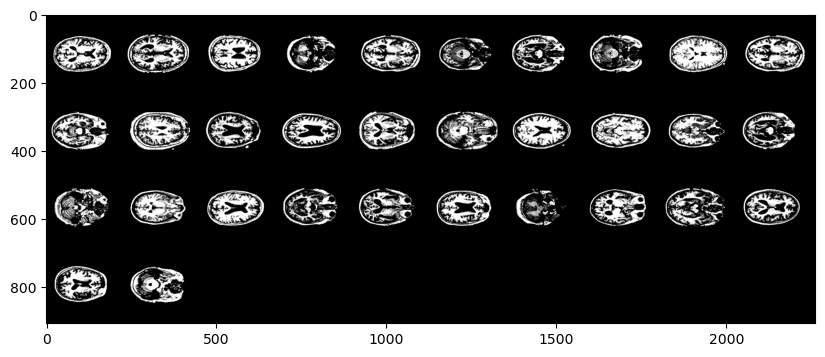

Advanced Alzheimers   Mild Alzheimers   Advanced Alzheimers   No Alzheimers   Mild Alzheimers   No Alzheimers   Advanced Alzheimers   Mild Alzheimers   No Alzheimers   Mild Alzheimers


In [76]:
# Test how the images look

# Function to show image
def show_image(img):
    img = img.numpy()
    plt.figure(figsize=(20, 4))
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

iteration = iter(train_loader)
images, labels = next(iteration)

show_image(torchvision.utils.make_grid(images, nrow=10))
classes = ("No Alzheimers", "Mild Alzheimers", "Advanced Alzheimers")
print("   ".join('%5s' % classes[labels[j]] for j in range(10)))


# Model Implementation

### Implement AlzheimersViT Class

In [77]:
from torchvision.models import vit_b_16, ViT_B_16_Weights

In [78]:
class AlzheimersViT(nn.Module):
    
    def __init__(self):
        super(AlzheimersViT, self).__init__()
        self.model = vit_b_16(weights=ViT_B_16_Weights.DEFAULT)

        self.model.heads.head = nn.Linear(in_features=768, out_features=3, bias=True)
        
    def forward(self, x):
        return self.model(x)

# Training Implementation

In [85]:
# Choose the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create an instance of the Network
vit = AlzheimersViT()

# Loss and optimizer to use
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(vit.parameters(), lr=0.001, momentum=0.9)

# Moving network parameters to the chosen device
vit.to(device)

AlzheimersViT(
  (model): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (ln_1): L

In [86]:
from tqdm import tqdm
# Training Procedure

avg_losses = []
avg_accuracies = []
epochs = 2
print_freq = 10

for epoch in tqdm(range(epochs), desc="Training Completion"):
    running_loss = 0.0
    total_samples = 0
    correct_predictions = 0
    for batch, data in enumerate(train_loader, 0):
        
        inputs, labels = data
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zeroing the gradients
        optimizer.zero_grad()
        
        # Generate predictions
        outputs = vit(inputs)
        
        # Compute loss based on predictions and ground truth
        loss = loss_func(outputs, labels)
        
        # Take backwards step
        loss.backward()
        
        # Update the network parameters
        optimizer.step()
        
        running_loss += loss.item()
        
        if batch % print_freq == print_freq - 1:
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss and accuracy: {:.3f}'.format(
                epoch, batch, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0
            

print('Training Complete.')

Training Completion:   0%|          | 0/2 [00:00<?, ?it/s]

[epoch: 0, i:     9] avg mini-batch loss and accuracy: 1.106
[epoch: 0, i:    19] avg mini-batch loss and accuracy: 1.040
[epoch: 0, i:    29] avg mini-batch loss and accuracy: 1.015
[epoch: 0, i:    39] avg mini-batch loss and accuracy: 0.885
[epoch: 0, i:    49] avg mini-batch loss and accuracy: 0.713
[epoch: 0, i:    59] avg mini-batch loss and accuracy: 0.565
[epoch: 0, i:    69] avg mini-batch loss and accuracy: 0.542
[epoch: 0, i:    79] avg mini-batch loss and accuracy: 0.472
[epoch: 0, i:    89] avg mini-batch loss and accuracy: 0.378
[epoch: 0, i:    99] avg mini-batch loss and accuracy: 0.328
[epoch: 0, i:   109] avg mini-batch loss and accuracy: 0.206
[epoch: 0, i:   119] avg mini-batch loss and accuracy: 0.196
[epoch: 0, i:   129] avg mini-batch loss and accuracy: 0.205
[epoch: 0, i:   139] avg mini-batch loss and accuracy: 0.171


Training Completion:  50%|█████     | 1/2 [02:10<02:10, 130.54s/it]

[epoch: 1, i:     9] avg mini-batch loss and accuracy: 0.106
[epoch: 1, i:    19] avg mini-batch loss and accuracy: 0.071
[epoch: 1, i:    29] avg mini-batch loss and accuracy: 0.152
[epoch: 1, i:    39] avg mini-batch loss and accuracy: 0.085
[epoch: 1, i:    49] avg mini-batch loss and accuracy: 0.068
[epoch: 1, i:    59] avg mini-batch loss and accuracy: 0.090
[epoch: 1, i:    69] avg mini-batch loss and accuracy: 0.066
[epoch: 1, i:    79] avg mini-batch loss and accuracy: 0.042
[epoch: 1, i:    89] avg mini-batch loss and accuracy: 0.072
[epoch: 1, i:    99] avg mini-batch loss and accuracy: 0.059
[epoch: 1, i:   109] avg mini-batch loss and accuracy: 0.056
[epoch: 1, i:   119] avg mini-batch loss and accuracy: 0.035
[epoch: 1, i:   129] avg mini-batch loss and accuracy: 0.080
[epoch: 1, i:   139] avg mini-batch loss and accuracy: 0.054


Training Completion: 100%|██████████| 2/2 [04:20<00:00, 130.28s/it]

Training Complete.


### Training Loss and Accuracy Curve

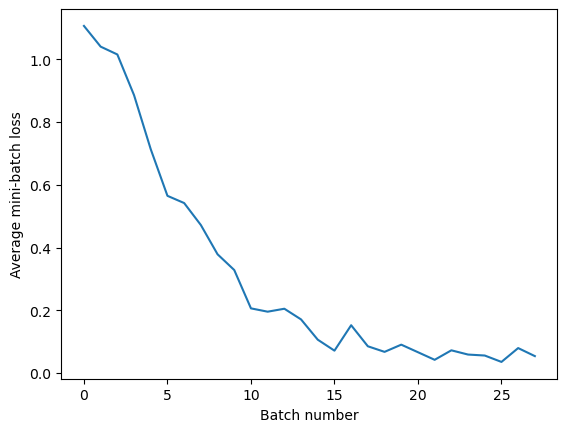

In [87]:
plt.plot(avg_losses)
plt.xlabel("Batch number")
plt.ylabel("Average mini-batch loss")
plt.show()

# Evaluation

In [88]:
# Test Accuracy

total_samples = 0
correct_predictions = 0

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = vit(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        
        total_samples += labels.size(0)
        
        correct_predictions += (predicted == labels).sum().item()
        
        

print("Accuracy of the Network on Test Data: ", (100 * (correct_predictions/total_samples)))

Accuracy of the Network on Test Data:  53.78024193548387


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


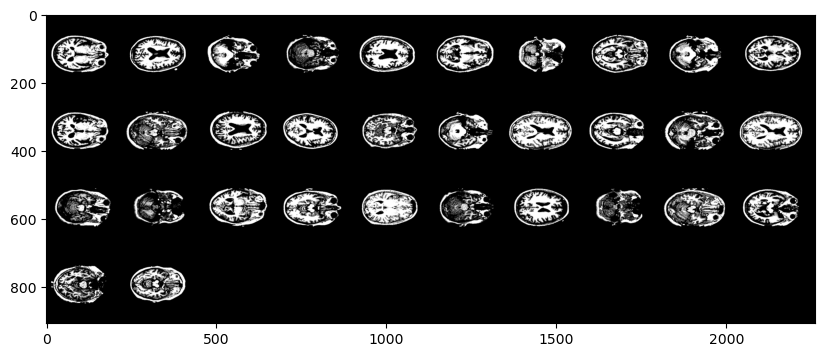

Predictions:   Mild Alzheimers Advanced Alzheimers Mild Alzheimers No Alzheimers Advanced Alzheimers Advanced Alzheimers Mild Alzheimers No Alzheimers Mild Alzheimers Advanced Alzheimers
Ground Truth:  Advanced Alzheimers Advanced Alzheimers Mild Alzheimers No Alzheimers Advanced Alzheimers Advanced Alzheimers Mild Alzheimers Mild Alzheimers Mild Alzheimers No Alzheimers


In [89]:
# Visualize a few predictions
iteration = iter(test_loader)
images, labels = next(iteration)
images, labels = next(iteration)
show_image(torchvision.utils.make_grid(images, nrow=10))
outputs = vit(images.to(device))
_, predictions = torch.max(outputs.data, 1)
classes = ("No Alzheimers", "Mild Alzheimers", "Advanced Alzheimers")
print("Predictions:  ", " ".join('%5s' % classes[predictions[i]] for i in range(10)))
print("Ground Truth: ", " ".join('%5s' % classes[labels[j]] for j in range(10)))

In [90]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(3))
class_total = list(0. for i in range(3))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vit(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(10):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(3):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of No Alzheimers : 74 %
Accuracy of Mild Alzheimers : 20 %
Accuracy of Advanced Alzheimers : 72 %
